TODO:
* Deal with very large matrix $K_{zx}$. When done with that, replace links in the beginning with links to the big dataset
* How to make ```imshow()``` of the large dataset?
* Implement maximum-likelihood determination of $\mu, \sigma^2$
* <strike>Deal with nonsquare data grids</strike>

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import pandas as pd 
from math import sqrt
from sklearn.metrics.pairwise import rbf_kernel
%matplotlib inline

In [2]:
import os
threeup = os.path.abspath('../../..')
#data_link = os.path.join(threeup, 'USGS_files.xyz')
#data_link = 'USGS_NED_one_meter.xyz'
data_link = os.path.join(threeup,
                         'USGS_NED_one_meter_x44y371_AL_3County_2015_IMG_2017.xyz')

In [3]:
#data_link = threeup + '\USGS_files.xyz'

#data_link = '././USGS_NED_one_meter_x44y371_AL_3County_2015_IMG_2017.xyz'

#Z_coord now keeps all the data (big list)
Z_coord = pd.read_csv(data_link,
                          header=None, engine='c', sep=' ', usecols='Z',
                          names=list('XYZ'), dtype={'Z':np.float32})
qty_dots = len(Z_coord)

# "list" used to get the position of the first point
init_xy = pd.read_csv(data_link,
                          nrows=1, header=None, engine='c', sep=' ', usecols='XY',
                          names=list('XYZ'), dtype={'X':np.float32, 'Y':np.float32, 'Z':np.float32})

# Here I load several lines of XY points
# so that I get the max value of x and 
# how many points span the x line
xy_data = pd.read_csv(data_link,
                          nrows=5*int(sqrt(qty_dots)) ,header=None, engine='c', sep=' ', usecols='XY',
                          names=list('XYZ'), dtype={'X':np.float32, 'Y':np.float32, 'Z':np.float32})

rowend = xy_data['X'].argmax()
dx = xy_data['X'][1] - xy_data['X'][0]
dy = xy_data['Y'][rowend + 1] - xy_data['Y'][0]
nx = rowend + 1
ny = int(qty_dots / nx)
print('dx=%2.2f, dy=%2.2f, nx=%d, ny=%d' % (dx, dy, nx, ny))
xy_data = []

dx=1.00, dy=-1.00, nx=10012, ny=10012


In [5]:
def make_coarse(Z_coord, dx, dy, nx, ny, rarity):
    gx  = np.arange(nx, dtype=np.int32)
    gy  = np.arange(ny, dtype=np.int32)
    xx, yy = np.meshgrid(gx[::rarity], gy[::rarity])
    #print(np.shape(xx))
    nx_coarse = np.shape(xx)[1]   ##sic
    ny_coarse = np.shape(xx)[0]
    qty_coarse = np.shape(xx)[0] * np.shape(xx)[1]
    
    xx_r = xx.ravel().astype(np.int64)
    yy_r = yy.ravel().astype(np.int64)
    coarse_grid = np.vstack([xx_r,yy_r]).T
    indices = np.ravel_multi_index([yy_r,xx_r], dims=(ny, nx))
    z = Z_coord.iloc[indices]
    
    return coarse_grid, z, nx_coarse, ny_coarse, qty_coarse

In [6]:
rarity = 100
rarity_fine = 20 #preferably a divisor of rarity
coarse_grid, z, nx_coarse, ny_coarse, qty_coarse = make_coarse(Z_coord, dx, dy, nx, ny, rarity)
fine_grid, z_fine, nx_fine, ny_fine, qty_fine = make_coarse(Z_coord, dx, dy, nx, ny, rarity_fine)
print(nx_coarse, ny_coarse)
print(nx_fine, ny_fine)

101 101
501 501


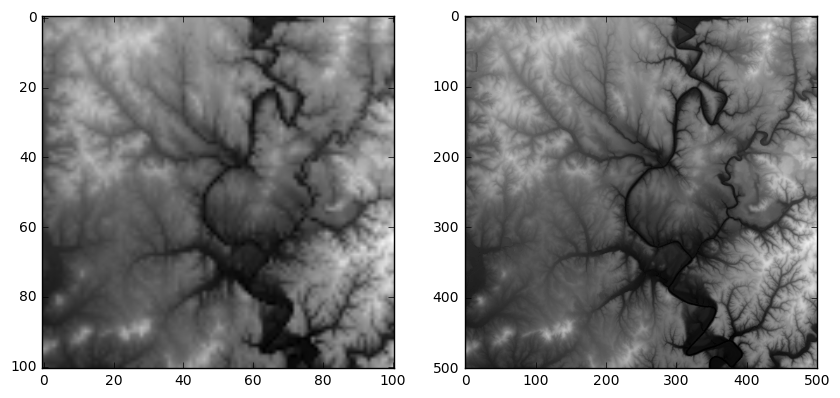

In [7]:
coarse_data = z.values.reshape(ny_coarse, nx_coarse)
fine_data = z_fine.values.reshape(ny_fine, nx_fine)
#super_fine_data = Z_coord.values.reshape(ny, nx)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(coarse_data, cmap=plt.cm.gray)
plt.subplot(122)
plt.imshow(fine_data, cmap=plt.cm.gray)
plt.show()

In [8]:
sigma = 0.7*dx*rarity

def krige_matvec(vec, nx, ny, dx=1, dy=1, sigma=3.): 
    #print('nx %d ny %d dx %f dy %f' % (nx, ny, dx, dy))
    
    tx = np.exp(-1/(sigma**2) * (dx**2) * (np.arange(nx))**2)  
    ty = np.exp(-1/(sigma**2) * (dy**2) * (np.arange(ny))**2) 
    upper_block = np.kron(np.expand_dims(tx, axis=1), np.expand_dims(ty, axis=0))
    horz_circ = np.concatenate((upper_block, np.flip(upper_block, axis=0)[:-1]), axis=0)
    tot_circ = np.concatenate((horz_circ, np.flip(horz_circ, axis=1)[:,:-1]), axis=1)
    #print(np.shape(tot_circ))
    
    vec_mat = np.reshape(vec, ((nx,ny)))
    vec_padded = np.pad(vec_mat, ((0,nx-1),(0,ny-1)),'constant')
    #print(np.shape(vec_padded))
    
    out = np.fft.ifft2(np.fft.fft2(tot_circ) * np.fft.fft2(vec_padded))[:nx, :ny]
    return np.reshape(out, (nx*ny,1)).squeeze()

In [9]:
Kxx_LO = scipy.sparse.linalg.LinearOperator((qty_coarse, qty_coarse), 
                                            matvec=lambda v, sigma=sigma, nx=nx_coarse, ny=ny_coarse, 
                                            dx=dx*rarity, dy=dy*rarity: 
                                            krige_matvec(v, nx=nx, ny=ny, dx=dx, dy=dy, sigma=sigma))

In [10]:
###epsilon = 1e-3
###regularize = epsilon * sp.sparse.identity(qty_coarse)
###krige = sp.sparse.linalg.gmres(Kxx_LO + sp.sparse.linalg.aslinearoperator(regularize), z, maxiter=15)

In [11]:
epsilon = 1e-4   # Do we really need this?
regularize = epsilon * sp.sparse.identity(qty_coarse)
#krige = sp.sparse.linalg.gmres(Kxx_LO + sp.sparse.linalg.aslinearoperator(regularize), z, maxiter=15)
#Kxx_c = Kxx_LO.dot(krige[0]).real
maxiter = 100
numerator = sp.sparse.linalg.gmres(Kxx_LO + sp.sparse.linalg.aslinearoperator(regularize),
                                   z, maxiter=maxiter)
numerator = np.sum(numerator[0].real)
denominator = sp.sparse.linalg.gmres(Kxx_LO + sp.sparse.linalg.aslinearoperator(regularize), 
                                     np.ones((qty_coarse, 1)), maxiter=maxiter)
denominator = np.sum(denominator[0].real)
mu = numerator / denominator
#mu = 0

c = sp.sparse.linalg.gmres(Kxx_LO + sp.sparse.linalg.aslinearoperator(regularize),
                           z - mu*np.ones((qty_coarse, 1)), maxiter=maxiter)



Kxx_c = Kxx_LO.dot(c[0]).real + mu
deviation = 1/qty_coarse * np.dot((z - mu*np.ones((qty_coarse, 1))).squeeze(), c[0]).real  ## sigma^2 in notations of the article

In [12]:
#Kxx_c = Kxx_LO.dot(krige[0]).real

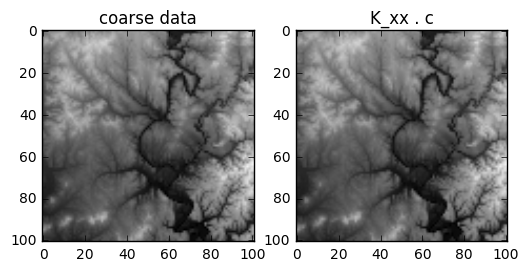

In [13]:
plt.subplot(121)
plt.imshow(coarse_data, cmap=plt.cm.gray)
plt.title('coarse data')

plt.subplot(122)
plt.imshow(np.reshape(Kxx_c, (ny_coarse,nx_coarse)), cmap=plt.cm.gray)
plt.title('K_xx . c')
plt.show()

In [14]:
# This is essentially rowwise matvec of Kzx.
# It doesn't hang up the computer or fill the memory,
# but it takes at least several minutes to get done.


fine_krige = mu*np.ones((nx_fine*ny_fine, 1))
for i in range(0, qty_fine):
    data_point = fine_grid[i].reshape(1, -1)
    Kzx_line = rbf_kernel(data_point, coarse_grid, gamma=1/sigma**2)
    fine_krige[i] += Kzx_line.dot(c[0]).real[0]

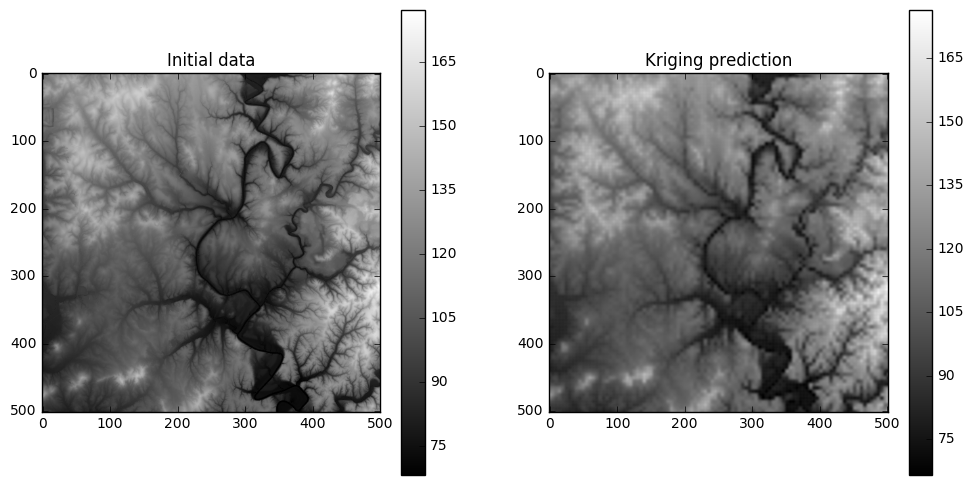

In [16]:
#nx = int(sqrt(np.shape(fine_data)[0]))
plt.figure(figsize=(12,6))

plt.subplot(121)
#plt.imshow(np.reshape(Z_coord.values, (ny,nx)), cmap=plt.cm.gray)
plt.imshow(fine_data, cmap=plt.cm.gray)
plt.title('Initial data')
plt.colorbar()

plt.subplot(122)
plt.imshow(np.reshape(fine_krige, (ny_fine, nx_fine)), cmap=plt.cm.gray)
plt.title('Kriging prediction')
plt.colorbar()

#plt.subplot(133)
#plt.imshow(abs(fine_data - np.reshape(fine_krige, (ny_fine, nx_fine))), cmap=plt.cm.gray)
#plt.title('|Initial - Kriging|')
#plt.colorbar()

plt.show()

In [17]:
err_norm = np.linalg.norm(fine_data - np.reshape(fine_krige, (ny_fine, nx_fine)))
data_norm = np.linalg.norm(fine_data)
print('Relative error = %f' % (err_norm / data_norm))

Relative error = 0.026025


In [18]:
np.save("fine_krige", fine_krige)